In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import librosa 
from pywavefront import Wavefront

In [5]:
class AudioEncoder(tf.keras.Model):
    def __init__(self, latent_dim=128):
        super(AudioEncoder, self).__init__()

        self.melspec = tf.keras.layers.Conv1D(128, kernel_size=5, strides=2, activation='relu', padding='same')
        self.convs = [
            tf.keras.layers.Conv1D(128, kernel_size=5, dilation_rate=dilation, activation='relu', padding='same')
            for dilation in [2, 4, 6, 2, 4, 6]
        ]
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(latent_dim, activation='relu')

    def call(self, x):
        x = self.melspec(x)
        for conv in self.convs:
            x = conv(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [6]:
class ExpressionEncoder(tf.keras.Model):
    def __init__(self, latent_dim=128):
        super(ExpressionEncoder, self).__init__()

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(latent_dim, activation='linear')

        self.lstm = tf.keras.layers.LSTM(128, return_sequences=True)

    def call(self, x):
        # Reshape input to (batch_size * timesteps, vertices * dimensions)
        batch_size, timesteps, vertices, dimensions = x.shape
        x = tf.reshape(x, (-1, vertices * dimensions))

        x = self.dense(x)
        
        # Reshape back to (batch_size, timesteps, latent_dim)
        x = tf.reshape(x, (batch_size, timesteps, -1))
        
        x = self.lstm(x)
        return x

In [17]:
# Create instances of the encoders
audio_encoder = AudioEncoder()
expression_encoder = ExpressionEncoder()

# Load real audio data from a WAV file
audio_file_path = "D:/meshtalk/govind/govind/multiface/data/m--20180227--0000--6795937--GHS/audio/SEN_a_good_morrow_to_you_my_boy.wav"
audio_waveform, sample_rate = librosa.load(audio_file_path, sr=None, mono=True)

# Convert audio waveform to Mel spectrogram
n_fft = 2048
hop_length = 160
mel_spectrogram = librosa.feature.melspectrogram(y=audio_waveform, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=128)

# Transpose to have shape (time_steps, features)
mel_spectrogram = mel_spectrogram.T

# Expand dimensions to add batch size
audio_input = tf.expand_dims(mel_spectrogram, axis=0)

# Load real face mesh data from an OBJ file
obj_file_path = "D:/meshtalk/govind/govind/multiface/data/m--20180227--0000--6795937--GHS/tracked_mesh/E057_Cheeks_Puffed/021897.obj"
mesh = Wavefront(obj_file_path)

# Assuming your face mesh data is in a format that can be directly used, no additional preprocessing needed
expression_input = mesh.vertices   # Load your face mesh data h

# Assuming your face mesh data is in a format that can be directly used, no additional preprocessing needed
expression_input = np.array(mesh.vertices)  # Convert to NumPy array
expression_input = np.expand_dims(expression_input, axis=0)  # Add batch dimension
expression_input = np.expand_dims(expression_input, axis=3)

audio_code = audio_encoder(audio_input)
expression_code = expression_encoder(expression_input)

print("Audio Code Shape:", audio_code.shape)
print("Expression Code Shape:", expression_code.shape)

Audio Code Shape: (1, 128)
Expression Code Shape: (1, 7306, 128)


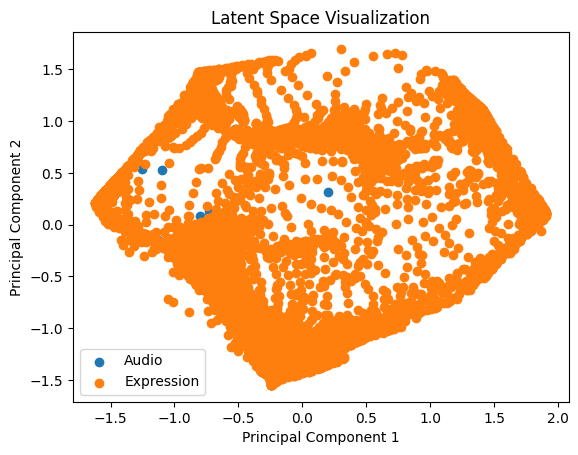

In [18]:
# Reshape expression_codes for compatibility with concatenation
expression_codes_reshaped = tf.reshape(expression_code, (expression_code.shape[0] * expression_code.shape[1], -1))

# Combine the audio and expression codes for visualization
all_codes = np.concatenate([audio_code, expression_codes_reshaped], axis=0)
# Perform PCA to reduce the dimensionality for visualization
pca = PCA(n_components=2)
reduced_codes = pca.fit_transform(all_codes)

num_samples = 16

audio_reduced = reduced_codes[:num_samples]
expression_reduced = reduced_codes[num_samples:]

plt.scatter(audio_reduced[:, 0], audio_reduced[:, 1], label='Audio')
plt.scatter(expression_reduced[:, 0], expression_reduced[:, 1], label='Expression')
plt.legend()
plt.title("Latent Space Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()